
# Connectivity Visualization

This notebook visualizes a `connectivity.pkl` file produced by your pipeline.
It expects a pickle with a Python object of type `list[list[int]]`, where each
inner list contains the IDs of satellites that are online during the given time slot.

**How to use:**
1. Set `PICKLE_PATH` below to point to your `connectivity.pkl`.
2. (Optional) Set `FIRST_N` to limit the visualization to the first N satellite IDs (after sorting).
3. Run the notebook cells in order.


In [1]:

from pathlib import Path

# --- Parameters ---
PICKLE_PATH = Path.cwd() / "connectivity" / "connectivity.pkl" # Path to the connectivity pickle file
FIRST_N = None  # e.g., 50 to visualize only the first 50 satellite IDs; None for all

# Output directory for any exports
OUT_DIR = PICKLE_PATH.parent
print("Using:", PICKLE_PATH.resolve())

if not PICKLE_PATH.exists():
    raise FileNotFoundError(f"Not found: {PICKLE_PATH} (cwd={Path.cwd()})")

Using: /mnt/c/Users/franf/workspace/Thesis/Github-Experiments/FedSpace-EFVFL/Experiments/connectivity/connectivity.pkl


In [2]:

import pickle
import numpy as np
import matplotlib.pyplot as plt

# Tool rule reminders:
# - Use matplotlib (done)
# - Each chart has its own distinct figure (done)
# - Do not set specific colors or styles (done)


In [3]:

def load_raw(path: Path):
    """Return the list-of-lists exactly as stored in the pickle file."""
    if not path.exists():
        raise FileNotFoundError(path)
    with path.open("rb") as f:
        return pickle.load(f)            # -> list[list[int]]


def build_intervals(raw, wanted_ids):
    """
    Convert the raw schedule to `intervals[row] == list[(start, span)]`.
    Useful if you want to extend with `Axes.broken_barh` later.
    """
    id2row = {sid: r for r, sid in enumerate(wanted_ids)}
    intervals = [[] for _ in wanted_ids]
    for ep, online in enumerate(raw):
        for sid in online:
            if sid in id2row:  # keep only the wanted satellites
                intervals[id2row[sid]].append((ep, 1))
    return intervals


In [4]:

# Load data
raw = load_raw(PICKLE_PATH)                 # e.g., 96 slots × satellite IDs
n_slots = len(raw)
all_ids = sorted({sid for slot in raw for sid in slot})

# Optionally restrict to first N satellites
wanted_ids = all_ids if FIRST_N is None else all_ids[:FIRST_N]
num_clients = len(wanted_ids)

# Compute metrics
intervals = build_intervals(raw, wanted_ids)

online_per_slot = [sum(1 for sid in slot if sid in wanted_ids) for slot in raw]

client_online_counts = np.zeros(num_clients, dtype=int)
id_to_idx = {sid: i for i, sid in enumerate(wanted_ids)}
for slot in raw:
    for sid in slot:
        idx = id_to_idx.get(sid, None)
        if idx is not None:
            client_online_counts[idx] += 1

print(f"Slots: {n_slots}")
print(f"Total unique satellites (considered): {num_clients}")
print(f"Min/Max online per slot: {min(online_per_slot)} / {max(online_per_slot)}")
print(f"Min/Max per-satellite online counts: {client_online_counts.min()} / {client_online_counts.max()}")


Slots: 96
Total unique satellites (considered): 149
Min/Max online per slot: 2 / 70
Min/Max per-satellite online counts: 4 / 33


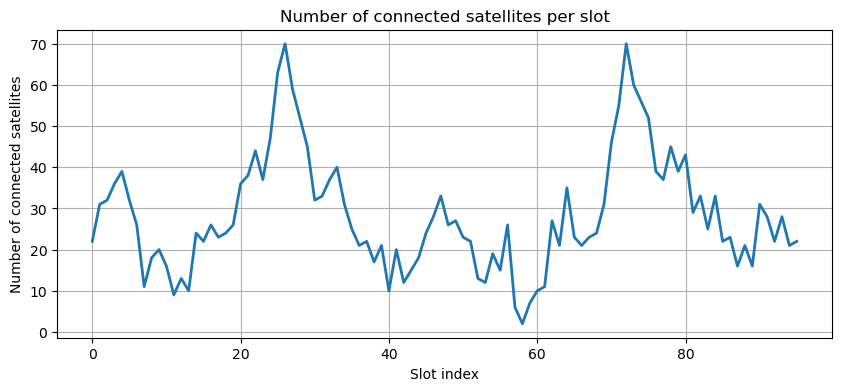

In [5]:

# Figure 1: Number of connected satellites per slot
plt.figure(figsize=(10, 4))
plt.plot(np.arange(n_slots), online_per_slot, linewidth=2)
plt.xlabel("Slot index")
plt.ylabel("Number of connected satellites")
plt.title("Number of connected satellites per slot")
plt.grid(True)
plt.show()


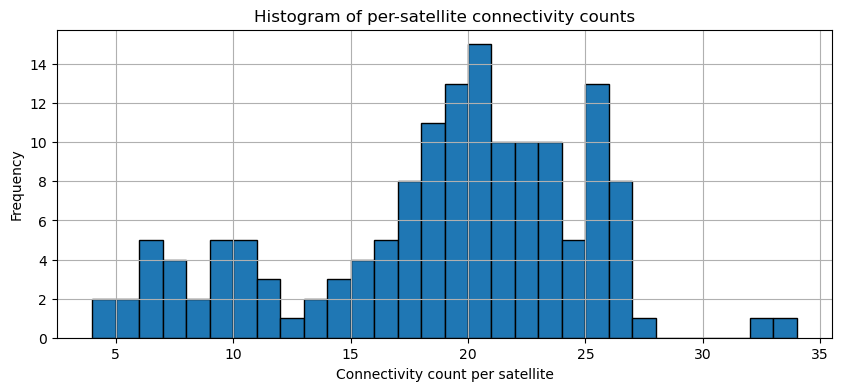

In [6]:

# Figure 2: Histogram of per-satellite connectivity counts
bins = np.arange(client_online_counts.min(), client_online_counts.max() + 2)  # unit-width bins
plt.figure(figsize=(10, 4))
plt.hist(client_online_counts, bins=bins, edgecolor="black")
plt.xlabel("Connectivity count per satellite")
plt.ylabel("Frequency")
plt.title("Histogram of per-satellite connectivity counts")
plt.grid(True)
plt.show()


In [7]:

from matplotlib.backends.backend_pdf import PdfPages

out_pdf = OUT_DIR / f"connectivity_plots_{'all' if FIRST_N is None else f'first{num_clients}'}" / "plots.pdf"

# Ensure directory exists
out_pdf.parent.mkdir(parents=True, exist_ok=True)

with PdfPages(out_pdf) as pdf:
    # Recreate figures to save them cleanly
    # Plot 1
    plt.figure(figsize=(10, 4))
    plt.plot(np.arange(n_slots), online_per_slot, linewidth=2)
    plt.xlabel("Slot index")
    plt.ylabel("Number of connected satellites")
    plt.title("Number of connected satellites per slot")
    plt.grid(True)
    pdf.savefig()
    plt.close()

    # Plot 2
    bins = np.arange(client_online_counts.min(), client_online_counts.max() + 2)
    plt.figure(figsize=(10, 4))
    plt.hist(client_online_counts, bins=bins, edgecolor="black")
    plt.xlabel("Connectivity count per satellite")
    plt.ylabel("Frequency")
    plt.title("Histogram of per-satellite connectivity counts")
    plt.grid(True)
    pdf.savefig()
    plt.close()

print(f"Saved PDF to: {out_pdf}")


Saved PDF to: /mnt/c/Users/franf/workspace/Thesis/Github-Experiments/FedSpace-EFVFL/Experiments/connectivity/connectivity_plots_all/plots.pdf
